In [3]:
# @title Step 1: Setup Awal dan Fungsi Utilitas
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize # Meskipun diimpor, tidak digunakan langsung di sini. Dapat dihapus jika tidak diperlukan nanti.
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams # Meskipun diimpor, tidak digunakan langsung di sini. Dapat dihapus jika tidak diperlukan nanti.
from nltk.probability import FreqDist # Meskipun diimpor, tidak digunakan langsung di sini. Dapat dihapus jika tidak diperlukan nanti.
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import pickle # Untuk menyimpan/memuat model, meskipun di Colab, lebih jarang digunakan karena sesi bersifat sementara.
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from google.colab import drive

print("Step 1: Mengimpor library dan mendefinisikan fungsi utilitas.")

# Mount Google Drive
drive.mount('/content/drive')
print("Google Drive berhasil di-mount.")

# Fungsi untuk menghitung jumlah kata dalam dokumen
def word_count(s):
    return len(s.split())

# Fungsi untuk menghapus tag HTML dari teks
def striphtml(text):
    p = re.compile('<.*?>')
    return p.sub('', text)

print("Fungsi utilitas 'word_count' dan 'striphtml' telah didefinisikan.")

Step 1: Mengimpor library dan mendefinisikan fungsi utilitas.
Mounted at /content/drive
Google Drive berhasil di-mount.
Fungsi utilitas 'word_count' dan 'striphtml' telah didefinisikan.


In [4]:
# @title Step 2: Memuat Data dan Pra-pemrosesan
print("Step 2: Memuat data dan pra-pemrosesan.")

# Ganti dengan jalur aktual ke dataset Anda di Google Drive
try:
    df = pd.read_csv("/content/drive/MyDrive/Twitter Dataset.csv")
    print(f"Dataset dimuat. Bentuk: {df.shape}")
    print("Melihat 5 baris pertama:")
    display(df.head())
except FileNotFoundError:
    print("ERROR: File 'Twitter Dataset.csv' tidak ditemukan di Google Drive Anda.")
    print("Pastikan Anda sudah mengunggahnya ke '/content/drive/MyDrive/' atau sesuaikan jalurnya.")
    # Exit or handle the error gracefully if you want the notebook to continue
    raise

# Menghapus tag HTML dan mengubah teks menjadi huruf kecil
df['tweet'] = df['tweet'].apply(striphtml)
df['tweet'] = df['tweet'].str.lower()
print("Pra-pemrosesan teks selesai (menghapus HTML, lowercase).")

# Memisahkan dataset menjadi dua bagian untuk pelatihan oracle dan eksperimen AAL
midpoint = len(df) // 2
df1 = df.iloc[:midpoint] # Untuk pelatihan oracle
df2 = df.iloc[midpoint:] # Untuk eksperimen active learning
print(f"Dataset dibagi: df1 (Oracle Training) shape={df1.shape}, df2 (AL Experiments) shape={df2.shape}")

# Inisialisasi dan FIT CountVectorizer pada data pelatihan oracle (df1)
# Ini memastikan kosakata yang konsisten untuk oracle dan main classifier di AL.
cv = CountVectorizer(lowercase=True, ngram_range=(1, 3))
cv.fit(df1['tweet']) # Fit CV on the oracle training data
print(f"CountVectorizer diinisialisasi dan di-fit pada data pelatihan Oracle. Jumlah fitur: {len(cv.vocabulary_)}")

print("CountVectorizer diinisialisasi.")

Step 2: Memuat data dan pra-pemrosesan.
Dataset dimuat. Bentuk: (7920, 3)
Melihat 5 baris pertama:


,id,label,tweet
0,1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
1,2,0,Finally a transparant silicon case ^^ Thanks t...
2,3,0,We love this! Would you go? #talk #makememorie...
3,4,0,I'm wired I know I'm George I was made that wa...
4,5,1,What amazing service! Apple won't even talk to...


Pra-pemrosesan teks selesai (menghapus HTML, lowercase).
Dataset dibagi: df1 (Oracle Training) shape=(3960, 3), df2 (AL Experiments) shape=(3960, 3)
CountVectorizer diinisialisasi dan di-fit pada data pelatihan Oracle. Jumlah fitur: 110087
CountVectorizer diinisialisasi.


In [5]:
# @title Step 3: Pelatihan Oracle Simulator
print("Step 3: Pelatihan Oracle Simulator.")

sampled_data_oracle = df1
y_oracle_full = sampled_data_oracle['label'] # Mengubah nama variabel menjadi y_oracle_full untuk kejelasan
encoder_oracle = LabelEncoder()
y_oracle_encoded = encoder_oracle.fit_transform(y_oracle_full) # Menggunakan y_oracle_encoded

X_train_oracle_text, X_test_oracle_text, y_train_oracle, y_test_oracle = train_test_split(
    sampled_data_oracle['tweet'], y_oracle_encoded, test_size=0.5, random_state=1
)

# Melatih CountVectorizer pada data pelatihan oracle - REMOVED FIT, using global cv
# X_train_bow_oracle = cv.fit_transform(X_train_oracle_text).toarray() # Menggunakan X_train_oracle_text

# Use the global cv fitted in Step 2
X_train_bow_oracle = cv.transform(X_train_oracle_text).toarray() # Use cv.transform

print(f"Data pelatihan Oracle di-vectorize. Bentuk BOW: {X_train_bow_oracle.shape}")

# Melatih model oracle (Logistic Regression)
# Perbaikan: Menggunakan y_train_oracle yang sudah dipisah
oracle = LogisticRegression(penalty='l2', C=0.01, multi_class='ovr', solver='liblinear', max_iter=1000).fit(X_train_bow_oracle, y_train_oracle)
print("Model Oracle (Logistic Regression) berhasil dilatih.")

# Fungsi oracle answering (mengembalikan -1 untuk netral)
def answer(oracle_model, x_bow_subinstance):
    # Mensimulasikan kepastian oracle berdasarkan probabilitas prediksi
    # Jika ketidakpastian (1 - prob_maks) > ambang batas (0.4), kembalikan -1 (netral)
    # Jika tidak, kembalikan label yang diprediksi
    # Check if x_bow_subinstance is empty
    if x_bow_subinstance.shape[0] == 0 or x_bow_subinstance.sum() == 0:
         return -1 # Return neutral if the vectorized instance is empty

    if 1 - np.max(oracle_model.predict_proba(x_bow_subinstance)[0]) > 0.4:
        return -1
    return oracle_model.predict(x_bow_subinstance)[0]

print("Fungsi 'answer' untuk oracle telah didefinisikan.")

# Pemetaan biaya anotasi dari studi pengguna (Tabel 1 dari makalah)
# Mengasumsikan biaya dataset 'IMDB' sebagai proksi untuk dataset Twitter
COST_PER_K_WORDS = {
    10: 5.7,
    25: 8.2,
    50: 10.9,
    75: 15.9,
    100: 16.7,
    -1: 15.0 # Biaya untuk dokumen penuh (digunakan di Traditional AL)
}
print("Pemetaan biaya per jumlah kata telah didefinisikan.")

Step 3: Pelatihan Oracle Simulator.
Data pelatihan Oracle di-vectorize. Bentuk BOW: (1980, 110087)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Model Oracle (Logistic Regression) berhasil dilatih.
Fungsi 'answer' untuk oracle telah didefinisikan.
Pemetaan biaya per jumlah kata telah didefinisikan.


In [6]:
# @title Step 4: Pelatihan Pengklasifikasi Netralitas (untuk Dynamic AAL)
print("Step 4: Pelatihan Pengklasifikasi Netralitas.")

cv_neutrality_model = CountVectorizer(lowercase=True, ngram_range=(1, 3))

X_train_neutrality_text, X_test_neutrality_text, y_train_neutrality_raw, y_test_neutrality_raw = train_test_split(
    df1['tweet'], df1['label'], test_size=0.5, random_state=42
)

cv_neutrality_model.fit(X_train_neutrality_text)

neutrality_data = []
k_options_for_neutrality_training = [10, 25, 50, 75, 100, -1]

for k_size in k_options_for_neutrality_training:
    if k_size == -1:
        X_k_text_subset = X_train_neutrality_text
    else:
        X_k_text_subset = X_train_neutrality_text.apply(lambda x: ' '.join(x.split()[:k_size]))

    # Transform subset teks using cv_neutrality_model
    X_k_bow_subset = cv_neutrality_model.transform(X_k_text_subset)

    for i in range(X_k_bow_subset.shape[0]):
        # Vectorize the individual subinstance using the main cv object
        x_bow_single_instance = cv.transform([X_k_text_subset.iloc[i]])

        # Pass the vectorized subinstance to the 'answer' function
        oracle_response = answer(oracle_model=oracle, x_bow_subinstance=x_bow_single_instance)

        is_non_neutral = 1 if oracle_response != -1 else 0
        neutrality_data.append({'subinstance_bow': X_k_bow_subset[i], 'is_non_neutral': is_non_neutral})

neutrality_df = pd.DataFrame(neutrality_data)

if not neutrality_df.empty:
    from scipy.sparse import vstack
    X_neutrality = vstack(neutrality_df['subinstance_bow'].tolist())
    y_neutrality = neutrality_df['is_non_neutral'].values

    neutrality_classifier = LogisticRegression(penalty='l2', C=0.01, multi_class='ovr', solver='liblinear', max_iter=1000).fit(X_neutrality, y_neutrality)
    print("Pengklasifikasi netralitas berhasil dilatih.")

    def get_prob_non_neutral(neutrality_model, x_bow_subinstance):
        if x_bow_subinstance.shape[0] == 0:
            return 0.0
        return neutrality_model.predict_proba(x_bow_subinstance)[0, 1]
    print("Fungsi 'get_prob_non_neutral' telah didefinisikan.")
else:
    print("Peringatan: neutrality_df kosong. Pengklasifikasi netralitas tidak dapat dilatih.")
    neutrality_classifier = None

Step 4: Pelatihan Pengklasifikasi Netralitas.
Pengklasifikasi netralitas berhasil dilatih.
Fungsi 'get_prob_non_neutral' telah didefinisikan.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


In [7]:
# @title Step 5: Fungsi select_subinstance dan run_active_learning_experiment
print("Step 5: Mendefinisikan fungsi inti untuk eksperimen Active Learning.")

# Fungsi select_subinstance diperbarui untuk menerima teks input dan CV yang sesuai
def select_subinstance(main_classifier_model, oracle_model_for_neutrality, k_options=None, utility_func='uncertainty', X_test_full_text=None, U_indices=None):
    best_score = -np.inf
    selected_idx_in_U_pool_current = -1
    selected_k_size = -1

    if k_options is None: # Static AAL or Traditional AL
        U_current_texts_for_selection = X_test_full_text.iloc[U_indices]
        U_current_bow_for_selection = cv.transform(U_current_texts_for_selection) # Gunakan cv global

        if utility_func == 'uncertainty':
            if U_current_bow_for_selection.shape[0] == 0: return -1, -1
            probabilities = main_classifier_model.predict_proba(U_current_bow_for_selection)
            utilities = 1 - np.max(probabilities, axis=1)
        elif utility_func == 'constant':
            utilities = np.ones(U_current_bow_for_selection.shape[0])
        else:
            raise ValueError("utility_func must be 'uncertainty' or 'constant' for static/traditional AL.")

        if len(utilities) > 0:
            selected_idx_in_U_pool_current = np.argmax(utilities)

        return selected_idx_in_U_pool_current, k_options # k_options akan menjadi None untuk statis/tradisional

    else: # Dynamic AAL
        candidate_scores = []
        candidate_unlabeled_indices_in_U_indices = []
        candidate_k_sizes = []

        for u_idx_in_pool_current in range(len(U_indices)):
            actual_X_test_idx = U_indices[u_idx_in_pool_current]
            full_instance_text = X_test_full_text.iloc[actual_X_test_idx]

            for k_size_option in k_options:
                if k_size_option == -1:
                    x_sub_text = full_instance_text
                else:
                    x_sub_text = ' '.join(full_instance_text.split()[:k_size_option])

                if not x_sub_text.strip():
                    continue

                x_sub_bow_main = cv.transform([x_sub_text]) # Gunakan cv global untuk main_classifier

                if utility_func == 'uncertainty':
                    main_classifier_probs = main_classifier_model.predict_proba(x_sub_bow_main)
                    utility = 1 - np.max(main_classifier_probs)
                elif utility_func == 'constant':
                    utility = 1.0
                else:
                    raise ValueError("utility_func must be 'uncertainty' or 'constant' for dynamic AL.")

                if oracle_model_for_neutrality is not None:
                    # Untuk netralitas, kita harus menggunakan cv_neutrality_model yang spesifik
                    x_sub_bow_neutrality = cv_neutrality_model.transform([x_sub_text])
                    prob_non_neutral = get_prob_non_neutral(oracle_model_for_neutrality, x_sub_bow_neutrality)
                else:
                    prob_non_neutral = 1.0

                cost_of_subinstance = COST_PER_K_WORDS.get(k_size_option, 15)

                score = (utility * prob_non_neutral) / cost_of_subinstance

                candidate_scores.append(score)
                candidate_unlabeled_indices_in_U_indices.append(u_idx_in_pool_current)
                candidate_k_sizes.append(k_size_option)

        if not candidate_scores:
            return -1, -1

        best_overall_idx_in_candidates = np.argmax(candidate_scores)
        selected_idx_in_U_pool_current = candidate_unlabeled_indices_in_U_indices[best_overall_idx_in_candidates]
        selected_k_size = candidate_k_sizes[best_overall_idx_in_candidates]

    return selected_idx_in_U_pool_current, selected_k_size


def run_active_learning_experiment(
    X_train_initial_bow, y_train_initial, X_test_full_text, y_test_true,
    oracle_model, neutrality_model, budget_seconds,
    strategy_type, k_fixed=None, utility_func=None, k_options_dynamic=None
):
    L_bow = X_train_initial_bow.copy()
    y_L = y_train_initial.copy()

    U_indices = list(range(len(X_test_full_text)))

    current_cost = 0
    auc_history = []
    cost_history = []

    main_classifier = LogisticRegression(penalty='l2', C=0.01, multi_class='ovr', solver='liblinear', max_iter=1000)

    if L_bow.shape[0] > 0:
        main_classifier.fit(L_bow, y_L)
        X_test_bow_eval = cv.transform(X_test_full_text) # Gunakan cv global
        y_test_pred_eval = main_classifier.predict_proba(X_test_bow_eval)[:, 1]
        auc_history.append(roc_auc_score(y_test_true, y_test_pred_eval))
        cost_history.append(current_cost)
    else:
        auc_history.append(0.5)
        cost_history.append(current_cost)

    print(f"Starting {strategy_type} experiment. Initial Labeled: {y_L.shape[0]}, Initial AUC: {auc_history[-1]:.4f}")

    while current_cost < budget_seconds and len(U_indices) > 0:
        if strategy_type == 'dynamic':
            selected_idx_in_U_pool_current, selected_k_size = select_subinstance(
                main_classifier, neutrality_model, k_options=k_options_dynamic,
                utility_func=utility_func, X_test_full_text=X_test_full_text, U_indices=U_indices
            )
            if selected_idx_in_U_pool_current == -1:
                print("No more instances to query in dynamic AAL.")
                break

            actual_X_test_idx_for_query = U_indices[selected_idx_in_U_pool_current]
            X_query_full_text = X_test_full_text.iloc[actual_X_test_idx_for_query]

            if selected_k_size == -1:
                X_query_subinstance_text = X_query_full_text
            else:
                X_query_subinstance_text = ' '.join(X_query_full_text.split()[:selected_k_size])

            # Vectorize the subinstance text before passing to the oracle answer function
            x_sub_bow_oracle = cv.transform([X_query_subinstance_text])
            oracle_label = answer(oracle_model, x_sub_bow_oracle)

            query_cost = COST_PER_K_WORDS.get(selected_k_size, 15)

            U_indices.pop(selected_idx_in_U_pool_current)

        else: # Static AAL or Traditional AL
            selected_idx_in_U_pool_current, _ = select_subinstance(
                main_classifier, oracle_model, k_options=None, utility_func=utility_func,
                X_test_full_text=X_test_full_text, U_indices=U_indices
            )

            if selected_idx_in_U_pool_current == -1:
                print(f"No more instances to query in {strategy_type}.")
                break

            actual_X_test_idx_for_query = U_indices[selected_idx_in_U_pool_current]
            X_query_full_text = X_test_full_text.iloc[actual_X_test_idx_for_query]

            if strategy_type == 'static_aal':
                X_query_subinstance_text = ' '.join(X_query_full_text.split()[:k_fixed])
                # Vectorize the subinstance text before passing to the oracle answer function
                x_sub_bow_oracle = cv.transform([X_query_subinstance_text])
                oracle_label = answer(oracle_model, x_sub_bow_oracle)
                query_cost = COST_PER_K_WORDS.get(k_fixed, 15)
            else: # Traditional AL
                # For Traditional AL, we query the full instance and assume the oracle always provides a label.
                # Vectorize the full instance text before passing to the oracle answer function
                x_full_bow_oracle = cv.transform([X_query_full_text])
                oracle_label = answer(oracle_model, x_full_bow_oracle) # Traditional AL assumes oracle always answers
                query_cost = COST_PER_K_WORDS.get(-1, 15)

            U_indices.pop(selected_idx_in_U_pool_current)

        current_cost += query_cost

        if oracle_label != -1 or strategy_type == 'traditional_al':
            X_queried_full_bow = cv.transform([X_query_full_text]) # Gunakan cv global untuk main classifier's training

            from scipy.sparse import vstack
            if L_bow.shape[0] == 0:
                L_bow = X_queried_full_bow
            else:
                L_bow = vstack([L_bow, X_queried_full_bow])

            y_L = np.concatenate((y_L, [oracle_label]))

            if L_bow.shape[0] > 0:
                main_classifier.fit(L_bow, y_L)

            X_test_bow_eval = cv.transform(X_test_full_text)
            y_test_pred_eval = main_classifier.predict_proba(X_test_bow_eval)[:, 1]
            auc_history.append(roc_auc_score(y_test_true, y_test_pred_eval))
            cost_history.append(current_cost)
        else:
            auc_history.append(auc_history[-1])
            cost_history.append(current_cost)

        print(f"  Cost: {current_cost:.2f}, Labeled: {y_L.shape[0]}, AUC: {auc_history[-1]:.4f}")

    print(f"{strategy_type} experiment finished. Total Labeled: {y_L.shape[0]}, Final AUC: {auc_history[-1]:.4f}")
    return np.array(cost_history), np.array(auc_history)

Step 5: Mendefinisikan fungsi inti untuk eksperimen Active Learning.


In [9]:
# @title Step 6: Menyiapkan Data dan Menjalankan Eksperimen Active Learning
print("Step 6: Menyiapkan data dan menjalankan eksperimen Active Learning.")

# Siapkan data untuk eksperimen AL (menggunakan df2)
sampled_data_al = df2.sample(n=2400, random_state=14)
y_al = sampled_data_al['label']
encoder_al = LabelEncoder()
y_al = encoder_al.fit_transform(y_al)

# Pisahkan data ini menjadi set pelatihan awal (labeled) dan set tidak berlabel (unlabeled pool)
X_train_al_text, X_test_al_text, y_train_al, y_test_al = train_test_split(
    sampled_data_al['tweet'], y_al, test_size=0.5, random_state=1
)

# Vectorize X_train_al_text untuk data berlabel awal
# Penting: cv (global) sudah di-fit di Step 2. Sekarang hanya perlu transform.
# cv.fit(X_train_al_text) # REMOVED: Avoid refitting cv
X_train_al_bow = cv.transform(X_train_al_text) # Transform ke sparse matrix
print(f"Data pelatihan awal untuk AL di-vectorize. Bentuk BOW: {X_train_al_bow.shape}")

budget = 500 # 50 menit dalam detik (50 * 60 = 3000)

print("\n--- Menjalankan Eksperimen ---")

# 1. Static Anytime Active Learning (k=10, Uncertainty)
print("\n--- Running Static AAL (k=10, Unc) ---")
cost_static_k10_unc, auc_static_k10_unc = run_active_learning_experiment(
    X_train_al_bow, y_train_al, X_test_al_text, y_test_al,
    oracle, neutrality_classifier, budget,
    strategy_type='static_aal', k_fixed=10, utility_func='uncertainty'
)

# 2. Static Anytime Active Learning (k=25, Uncertainty)
print("\n--- Running Static AAL (k=25, Unc) ---")
cost_static_k25_unc, auc_static_k25_unc = run_active_learning_experiment(
    X_train_al_bow, y_train_al, X_test_al_text, y_test_al,
    oracle, neutrality_classifier, budget,
    strategy_type='static_aal', k_fixed=25, utility_func='uncertainty'
)

# 3. Static Anytime Active Learning (k=100, Uncertainty)
print("\n--- Running Static AAL (k=100, Unc) ---")
cost_static_k100_unc, auc_static_k100_unc = run_active_learning_experiment(
    X_train_al_bow, y_train_al, X_test_al_text, y_test_al,
    oracle, neutrality_classifier, budget,
    strategy_type='static_aal', k_fixed=100, utility_func='uncertainty'
)

# 4. Traditional Active Learning (dokumen penuh, tanpa pemodelan netralitas)
print("\n--- Running Traditional AL (Unc) ---")
cost_traditional_al, auc_traditional_al = run_active_learning_experiment(
    X_train_al_bow, y_train_al, X_test_al_text, y_test_al,
    oracle, neutrality_classifier, budget, # neutrality_model tidak digunakan di Traditional AL
    strategy_type='traditional_al', k_fixed=-1, utility_func='uncertainty' # k_fixed=-1 mengindikasikan dokumen penuh
)

# 5. Dynamic Anytime Active Learning (Uncertainty)
print("\n--- Running Dynamic AAL (Unc) ---")
k_options_dynamic_aal = [10, 25, 50, 75, 100, -1] # -1 untuk dokumen penuh
cost_dynamic_unc, auc_dynamic_unc = run_active_learning_experiment(
    X_train_al_bow, y_train_al, X_test_al_text, y_test_al,
    oracle, neutrality_classifier, budget,
    strategy_type='dynamic', k_options_dynamic=k_options_dynamic_aal, utility_func='uncertainty'
)

# 6. Dynamic Anytime Active Learning (Constant Utility - hanya memaksimalkan probabilitas non-netral)
print("\n--- Running Dynamic AAL (Const) ---")
cost_dynamic_const, auc_dynamic_const = run_active_learning_experiment(
    X_train_al_bow, y_train_al, X_test_al_text, y_test_al,
    oracle, neutrality_classifier, budget,
    strategy_type='dynamic', k_options_dynamic=k_options_dynamic_aal, utility_func='constant'
)

print("\n--- Semua eksperimen selesai ---")

Step 6: Menyiapkan data dan menjalankan eksperimen Active Learning.
Data pelatihan awal untuk AL di-vectorize. Bentuk BOW: (1200, 110087)

--- Menjalankan Eksperimen ---

--- Running Static AAL (k=10, Unc) ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Starting static_aal experiment. Initial Labeled: 1200, Initial AUC: 0.9285
  Cost: 5.70, Labeled: 1200, AUC: 0.9285
  Cost: 11.40, Labeled: 1200, AUC: 0.9285
  Cost: 17.10, Labeled: 1200, AUC: 0.9285
  Cost: 22.80, Labeled: 1200, AUC: 0.9285
  Cost: 28.50, Labeled: 1200, AUC: 0.9285
  Cost: 34.20, Labeled: 1200, AUC: 0.9285
  Cost: 39.90, Labeled: 1200, AUC: 0.9285
  Cost: 45.60, Labeled: 1200, AUC: 0.9285
  Cost: 51.30, Labeled: 1200, AUC: 0.9285
  Cost: 57.00, Labeled: 1200, AUC: 0.9285
  Cost: 62.70, Labeled: 1200, AUC: 0.9285
  Cost: 68.40, Labeled: 1200, AUC: 0.9285
  Cost: 74.10, Labeled: 1200, AUC: 0.9285
  Cost: 79.80, Labeled: 1200, AUC: 0.9285
  Cost: 85.50, Labeled: 1200, AUC: 0.9285
  Cost: 91.20, Labeled: 1200, AUC: 0.9285
  Cost: 96.90, Labeled: 1200, AUC: 0.9285
  Cost: 102.60, Labeled: 1200, AUC: 0.9285
  Cost: 108.30, Labeled: 1200, AUC: 0.9285
  Cost: 114.00, Labeled: 1200, AUC: 0.9285
  Cost: 119.70, Labeled: 1200, AUC: 0.9285
  Cost: 125.40, Labeled: 1200, AUC: 0.92

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 387.60, Labeled: 1201, AUC: 0.9286
  Cost: 393.30, Labeled: 1202, AUC: 0.9287


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 399.00, Labeled: 1202, AUC: 0.9287
  Cost: 404.70, Labeled: 1202, AUC: 0.9287
  Cost: 410.40, Labeled: 1202, AUC: 0.9287
  Cost: 416.10, Labeled: 1202, AUC: 0.9287
  Cost: 421.80, Labeled: 1202, AUC: 0.9287
  Cost: 427.50, Labeled: 1202, AUC: 0.9287
  Cost: 433.20, Labeled: 1202, AUC: 0.9287
  Cost: 438.90, Labeled: 1202, AUC: 0.9287
  Cost: 444.60, Labeled: 1202, AUC: 0.9287
  Cost: 450.30, Labeled: 1202, AUC: 0.9287
  Cost: 456.00, Labeled: 1202, AUC: 0.9287
  Cost: 461.70, Labeled: 1202, AUC: 0.9287
  Cost: 467.40, Labeled: 1202, AUC: 0.9287
  Cost: 473.10, Labeled: 1202, AUC: 0.9287
  Cost: 478.80, Labeled: 1202, AUC: 0.9287
  Cost: 484.50, Labeled: 1202, AUC: 0.9287
  Cost: 490.20, Labeled: 1202, AUC: 0.9287
  Cost: 495.90, Labeled: 1202, AUC: 0.9287
  Cost: 501.60, Labeled: 1202, AUC: 0.9287
static_aal experiment finished. Total Labeled: 1202, Final AUC: 0.9287

--- Running Static AAL (k=25, Unc) ---
Starting static_aal experiment. Initial Labeled: 1200, Initial AUC: 0.92

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 8.20, Labeled: 1200, AUC: 0.9285
  Cost: 16.40, Labeled: 1200, AUC: 0.9285
  Cost: 24.60, Labeled: 1200, AUC: 0.9285
  Cost: 32.80, Labeled: 1200, AUC: 0.9285
  Cost: 41.00, Labeled: 1200, AUC: 0.9285
  Cost: 49.20, Labeled: 1200, AUC: 0.9285
  Cost: 57.40, Labeled: 1200, AUC: 0.9285
  Cost: 65.60, Labeled: 1200, AUC: 0.9285
  Cost: 73.80, Labeled: 1200, AUC: 0.9285
  Cost: 82.00, Labeled: 1200, AUC: 0.9285
  Cost: 90.20, Labeled: 1200, AUC: 0.9285
  Cost: 98.40, Labeled: 1200, AUC: 0.9285
  Cost: 106.60, Labeled: 1200, AUC: 0.9285
  Cost: 114.80, Labeled: 1200, AUC: 0.9285
  Cost: 123.00, Labeled: 1200, AUC: 0.9285
  Cost: 131.20, Labeled: 1200, AUC: 0.9285
  Cost: 139.40, Labeled: 1200, AUC: 0.9285
  Cost: 147.60, Labeled: 1200, AUC: 0.9285
  Cost: 155.80, Labeled: 1200, AUC: 0.9285
  Cost: 164.00, Labeled: 1200, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 172.20, Labeled: 1201, AUC: 0.9288
  Cost: 180.40, Labeled: 1201, AUC: 0.9288
  Cost: 188.60, Labeled: 1201, AUC: 0.9288
  Cost: 196.80, Labeled: 1201, AUC: 0.9288
  Cost: 205.00, Labeled: 1201, AUC: 0.9288


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 213.20, Labeled: 1202, AUC: 0.9289
  Cost: 221.40, Labeled: 1202, AUC: 0.9289


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 229.60, Labeled: 1203, AUC: 0.9291
  Cost: 237.80, Labeled: 1203, AUC: 0.9291


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 246.00, Labeled: 1204, AUC: 0.9289
  Cost: 254.20, Labeled: 1205, AUC: 0.9292
  Cost: 262.40, Labeled: 1205, AUC: 0.9292
  Cost: 270.60, Labeled: 1205, AUC: 0.9292
  Cost: 278.80, Labeled: 1205, AUC: 0.9292
  Cost: 287.00, Labeled: 1205, AUC: 0.9292
  Cost: 295.20, Labeled: 1205, AUC: 0.9292
  Cost: 303.40, Labeled: 1205, AUC: 0.9292
  Cost: 311.60, Labeled: 1205, AUC: 0.9292
  Cost: 319.80, Labeled: 1205, AUC: 0.9292
  Cost: 328.00, Labeled: 1205, AUC: 0.9292
  Cost: 336.20, Labeled: 1205, AUC: 0.9292
  Cost: 344.40, Labeled: 1205, AUC: 0.9292
  Cost: 352.60, Labeled: 1205, AUC: 0.9292
  Cost: 360.80, Labeled: 1205, AUC: 0.9292
  Cost: 369.00, Labeled: 1205, AUC: 0.9292
  Cost: 377.20, Labeled: 1205, AUC: 0.9292
  Cost: 385.40, Labeled: 1205, AUC: 0.9292
  Cost: 393.60, Labeled: 1205, AUC: 0.9292
  Cost: 401.80, Labeled: 1205, AUC: 0.9292
  Cost: 410.00, Labeled: 1205, AUC: 0.9292
  Cost: 418.20, Labeled: 1205, AUC: 0.9292
  Cost: 426.40, Labeled: 1205, AUC: 0.9292
  Cost: 434

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Starting static_aal experiment. Initial Labeled: 1200, Initial AUC: 0.9285
  Cost: 16.70, Labeled: 1200, AUC: 0.9285
  Cost: 33.40, Labeled: 1200, AUC: 0.9285
  Cost: 50.10, Labeled: 1200, AUC: 0.9285
  Cost: 66.80, Labeled: 1200, AUC: 0.9285
  Cost: 83.50, Labeled: 1200, AUC: 0.9285
  Cost: 100.20, Labeled: 1200, AUC: 0.9285
  Cost: 116.90, Labeled: 1200, AUC: 0.9285
  Cost: 133.60, Labeled: 1200, AUC: 0.9285
  Cost: 150.30, Labeled: 1200, AUC: 0.9285
  Cost: 167.00, Labeled: 1200, AUC: 0.9285
  Cost: 183.70, Labeled: 1200, AUC: 0.9285
  Cost: 200.40, Labeled: 1200, AUC: 0.9285
  Cost: 217.10, Labeled: 1200, AUC: 0.9285
  Cost: 233.80, Labeled: 1200, AUC: 0.9285
  Cost: 250.50, Labeled: 1200, AUC: 0.9285
  Cost: 267.20, Labeled: 1200, AUC: 0.9285
  Cost: 283.90, Labeled: 1200, AUC: 0.9285
  Cost: 300.60, Labeled: 1200, AUC: 0.9285
  Cost: 317.30, Labeled: 1200, AUC: 0.9285
  Cost: 334.00, Labeled: 1200, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 350.70, Labeled: 1201, AUC: 0.9288
  Cost: 367.40, Labeled: 1201, AUC: 0.9288
  Cost: 384.10, Labeled: 1201, AUC: 0.9288
  Cost: 400.80, Labeled: 1201, AUC: 0.9288
  Cost: 417.50, Labeled: 1201, AUC: 0.9288


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 434.20, Labeled: 1202, AUC: 0.9289
  Cost: 450.90, Labeled: 1202, AUC: 0.9289


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 467.60, Labeled: 1203, AUC: 0.9291
  Cost: 484.30, Labeled: 1203, AUC: 0.9291


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 501.00, Labeled: 1204, AUC: 0.9289
static_aal experiment finished. Total Labeled: 1204, Final AUC: 0.9289

--- Running Traditional AL (Unc) ---
Starting traditional_al experiment. Initial Labeled: 1200, Initial AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 15.00, Labeled: 1201, AUC: 0.0759


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 30.00, Labeled: 1202, AUC: 0.0759


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 45.00, Labeled: 1203, AUC: 0.0759


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 60.00, Labeled: 1204, AUC: 0.0759


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 75.00, Labeled: 1205, AUC: 0.0759


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 90.00, Labeled: 1206, AUC: 0.0759
  Cost: 105.00, Labeled: 1207, AUC: 0.0760


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 120.00, Labeled: 1208, AUC: 0.0760


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 135.00, Labeled: 1209, AUC: 0.0760


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 150.00, Labeled: 1210, AUC: 0.0759


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 165.00, Labeled: 1211, AUC: 0.0758


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 180.00, Labeled: 1212, AUC: 0.0757


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 195.00, Labeled: 1213, AUC: 0.0757


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 210.00, Labeled: 1214, AUC: 0.0757


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 225.00, Labeled: 1215, AUC: 0.0756


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 240.00, Labeled: 1216, AUC: 0.0756
  Cost: 255.00, Labeled: 1217, AUC: 0.0757


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 270.00, Labeled: 1218, AUC: 0.0756


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 285.00, Labeled: 1219, AUC: 0.0757


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 300.00, Labeled: 1220, AUC: 0.0756


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 315.00, Labeled: 1221, AUC: 0.0755


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 330.00, Labeled: 1222, AUC: 0.0754


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 345.00, Labeled: 1223, AUC: 0.0755


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 360.00, Labeled: 1224, AUC: 0.0754
  Cost: 375.00, Labeled: 1225, AUC: 0.0754
  Cost: 390.00, Labeled: 1226, AUC: 0.0755


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 405.00, Labeled: 1227, AUC: 0.0754


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 420.00, Labeled: 1228, AUC: 0.0755


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 435.00, Labeled: 1229, AUC: 0.0755


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 450.00, Labeled: 1230, AUC: 0.0755


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 465.00, Labeled: 1231, AUC: 0.0754


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 480.00, Labeled: 1232, AUC: 0.0754


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 495.00, Labeled: 1233, AUC: 0.0754


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 510.00, Labeled: 1234, AUC: 0.0755
traditional_al experiment finished. Total Labeled: 1234, Final AUC: 0.0755

--- Running Dynamic AAL (Unc) ---
Starting dynamic experiment. Initial Labeled: 1200, Initial AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 5.70, Labeled: 1201, AUC: 0.9286
  Cost: 11.40, Labeled: 1201, AUC: 0.9286
  Cost: 17.10, Labeled: 1201, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 22.80, Labeled: 1202, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 28.50, Labeled: 1203, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 34.20, Labeled: 1204, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 39.90, Labeled: 1205, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 45.60, Labeled: 1206, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 51.30, Labeled: 1207, AUC: 0.9285
  Cost: 57.00, Labeled: 1207, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 62.70, Labeled: 1208, AUC: 0.9285
  Cost: 68.40, Labeled: 1208, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 74.10, Labeled: 1209, AUC: 0.9285
  Cost: 79.80, Labeled: 1209, AUC: 0.9285
  Cost: 85.50, Labeled: 1209, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 91.20, Labeled: 1210, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 96.90, Labeled: 1211, AUC: 0.9286
  Cost: 102.60, Labeled: 1211, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 108.30, Labeled: 1212, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 114.00, Labeled: 1213, AUC: 0.9286
  Cost: 119.70, Labeled: 1213, AUC: 0.9286
  Cost: 125.40, Labeled: 1213, AUC: 0.9286
  Cost: 131.10, Labeled: 1213, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 136.80, Labeled: 1214, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 142.50, Labeled: 1215, AUC: 0.9286
  Cost: 148.20, Labeled: 1215, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 153.90, Labeled: 1216, AUC: 0.9286
  Cost: 159.60, Labeled: 1216, AUC: 0.9286
  Cost: 165.30, Labeled: 1216, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 171.00, Labeled: 1217, AUC: 0.9285
  Cost: 176.70, Labeled: 1217, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 182.40, Labeled: 1218, AUC: 0.9285
  Cost: 188.10, Labeled: 1218, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 193.80, Labeled: 1219, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 199.50, Labeled: 1220, AUC: 0.9285
  Cost: 205.20, Labeled: 1220, AUC: 0.9285
  Cost: 210.90, Labeled: 1220, AUC: 0.9285
  Cost: 216.60, Labeled: 1220, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 222.30, Labeled: 1221, AUC: 0.9285
  Cost: 228.00, Labeled: 1221, AUC: 0.9285
  Cost: 233.70, Labeled: 1221, AUC: 0.9285
  Cost: 239.40, Labeled: 1221, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 245.10, Labeled: 1222, AUC: 0.9285
  Cost: 253.30, Labeled: 1222, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 259.00, Labeled: 1223, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 264.70, Labeled: 1224, AUC: 0.9285
  Cost: 272.90, Labeled: 1224, AUC: 0.9285
  Cost: 278.60, Labeled: 1224, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 284.30, Labeled: 1225, AUC: 0.9285
  Cost: 290.00, Labeled: 1225, AUC: 0.9285
  Cost: 295.70, Labeled: 1225, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 301.40, Labeled: 1226, AUC: 0.9285
  Cost: 307.10, Labeled: 1226, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 312.80, Labeled: 1227, AUC: 0.9285
  Cost: 318.50, Labeled: 1227, AUC: 0.9285
  Cost: 324.20, Labeled: 1227, AUC: 0.9285
  Cost: 329.90, Labeled: 1227, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 335.60, Labeled: 1228, AUC: 0.9285
  Cost: 341.30, Labeled: 1228, AUC: 0.9285
  Cost: 347.00, Labeled: 1228, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 352.70, Labeled: 1229, AUC: 0.9286
  Cost: 358.40, Labeled: 1229, AUC: 0.9286
  Cost: 364.10, Labeled: 1229, AUC: 0.9286
  Cost: 372.30, Labeled: 1229, AUC: 0.9286
  Cost: 378.00, Labeled: 1229, AUC: 0.9286
  Cost: 383.70, Labeled: 1229, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 389.40, Labeled: 1230, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 395.10, Labeled: 1231, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 400.80, Labeled: 1232, AUC: 0.9286
  Cost: 406.50, Labeled: 1232, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 412.20, Labeled: 1233, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 417.90, Labeled: 1234, AUC: 0.9286
  Cost: 423.60, Labeled: 1234, AUC: 0.9286
  Cost: 429.30, Labeled: 1234, AUC: 0.9286
  Cost: 435.00, Labeled: 1234, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 440.70, Labeled: 1235, AUC: 0.9286
  Cost: 446.40, Labeled: 1235, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 452.10, Labeled: 1236, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 457.80, Labeled: 1237, AUC: 0.9287


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 463.50, Labeled: 1238, AUC: 0.9289


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 469.20, Labeled: 1239, AUC: 0.9289
  Cost: 474.90, Labeled: 1239, AUC: 0.9289
  Cost: 480.60, Labeled: 1239, AUC: 0.9289


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 486.30, Labeled: 1240, AUC: 0.9288
  Cost: 492.00, Labeled: 1240, AUC: 0.9288


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 497.70, Labeled: 1241, AUC: 0.9289


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 503.40, Labeled: 1242, AUC: 0.9289
dynamic experiment finished. Total Labeled: 1242, Final AUC: 0.9289

--- Running Dynamic AAL (Const) ---
Starting dynamic experiment. Initial Labeled: 1200, Initial AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 5.70, Labeled: 1201, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 11.40, Labeled: 1202, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 17.10, Labeled: 1203, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 22.80, Labeled: 1204, AUC: 0.9286


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 28.50, Labeled: 1205, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 34.20, Labeled: 1206, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 39.90, Labeled: 1207, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 45.60, Labeled: 1208, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 51.30, Labeled: 1209, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 57.00, Labeled: 1210, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 62.70, Labeled: 1211, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 68.40, Labeled: 1212, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 74.10, Labeled: 1213, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 79.80, Labeled: 1214, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 85.50, Labeled: 1215, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 91.20, Labeled: 1216, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 96.90, Labeled: 1217, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 102.60, Labeled: 1218, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 108.30, Labeled: 1219, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 114.00, Labeled: 1220, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 119.70, Labeled: 1221, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 125.40, Labeled: 1222, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 131.10, Labeled: 1223, AUC: 0.9285


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 136.80, Labeled: 1224, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 142.50, Labeled: 1225, AUC: 0.9284


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 148.20, Labeled: 1226, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 153.90, Labeled: 1227, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 159.60, Labeled: 1228, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 165.30, Labeled: 1229, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 171.00, Labeled: 1230, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 176.70, Labeled: 1231, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 182.40, Labeled: 1232, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 188.10, Labeled: 1233, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 193.80, Labeled: 1234, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 199.50, Labeled: 1235, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 205.20, Labeled: 1236, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 210.90, Labeled: 1237, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 216.60, Labeled: 1238, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 222.30, Labeled: 1239, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 228.00, Labeled: 1240, AUC: 0.9283


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 233.70, Labeled: 1241, AUC: 0.9282


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 239.40, Labeled: 1242, AUC: 0.9281


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 245.10, Labeled: 1243, AUC: 0.9281


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 250.80, Labeled: 1244, AUC: 0.9281


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 256.50, Labeled: 1245, AUC: 0.9281


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 262.20, Labeled: 1246, AUC: 0.9281


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 267.90, Labeled: 1247, AUC: 0.9281


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 273.60, Labeled: 1248, AUC: 0.9281


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 279.30, Labeled: 1249, AUC: 0.9280


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 285.00, Labeled: 1250, AUC: 0.9280


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 290.70, Labeled: 1251, AUC: 0.9280


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 296.40, Labeled: 1252, AUC: 0.9280


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 302.10, Labeled: 1253, AUC: 0.9280


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 307.80, Labeled: 1254, AUC: 0.9279


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 313.50, Labeled: 1255, AUC: 0.9279


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 319.20, Labeled: 1256, AUC: 0.9279


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 324.90, Labeled: 1257, AUC: 0.9279


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 330.60, Labeled: 1258, AUC: 0.9279


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 336.30, Labeled: 1259, AUC: 0.9278


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 342.00, Labeled: 1260, AUC: 0.9278


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 347.70, Labeled: 1261, AUC: 0.9278


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 353.40, Labeled: 1262, AUC: 0.9278


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 359.10, Labeled: 1263, AUC: 0.9277


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 364.80, Labeled: 1264, AUC: 0.9277


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 370.50, Labeled: 1265, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 376.20, Labeled: 1266, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 381.90, Labeled: 1267, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 387.60, Labeled: 1268, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 393.30, Labeled: 1269, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 399.00, Labeled: 1270, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 404.70, Labeled: 1271, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 410.40, Labeled: 1272, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 416.10, Labeled: 1273, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 421.80, Labeled: 1274, AUC: 0.9276


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 427.50, Labeled: 1275, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 433.20, Labeled: 1276, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 438.90, Labeled: 1277, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 444.60, Labeled: 1278, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 450.30, Labeled: 1279, AUC: 0.9274


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 456.00, Labeled: 1280, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 461.70, Labeled: 1281, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 467.40, Labeled: 1282, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 473.10, Labeled: 1283, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 478.80, Labeled: 1284, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 484.50, Labeled: 1285, AUC: 0.9275


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 490.20, Labeled: 1286, AUC: 0.9276


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


  Cost: 495.90, Labeled: 1287, AUC: 0.9275
  Cost: 501.60, Labeled: 1288, AUC: 0.9276
dynamic experiment finished. Total Labeled: 1288, Final AUC: 0.9276

--- Semua eksperimen selesai ---


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Step 7: Membuat plot perbandingan hasil eksperimen.


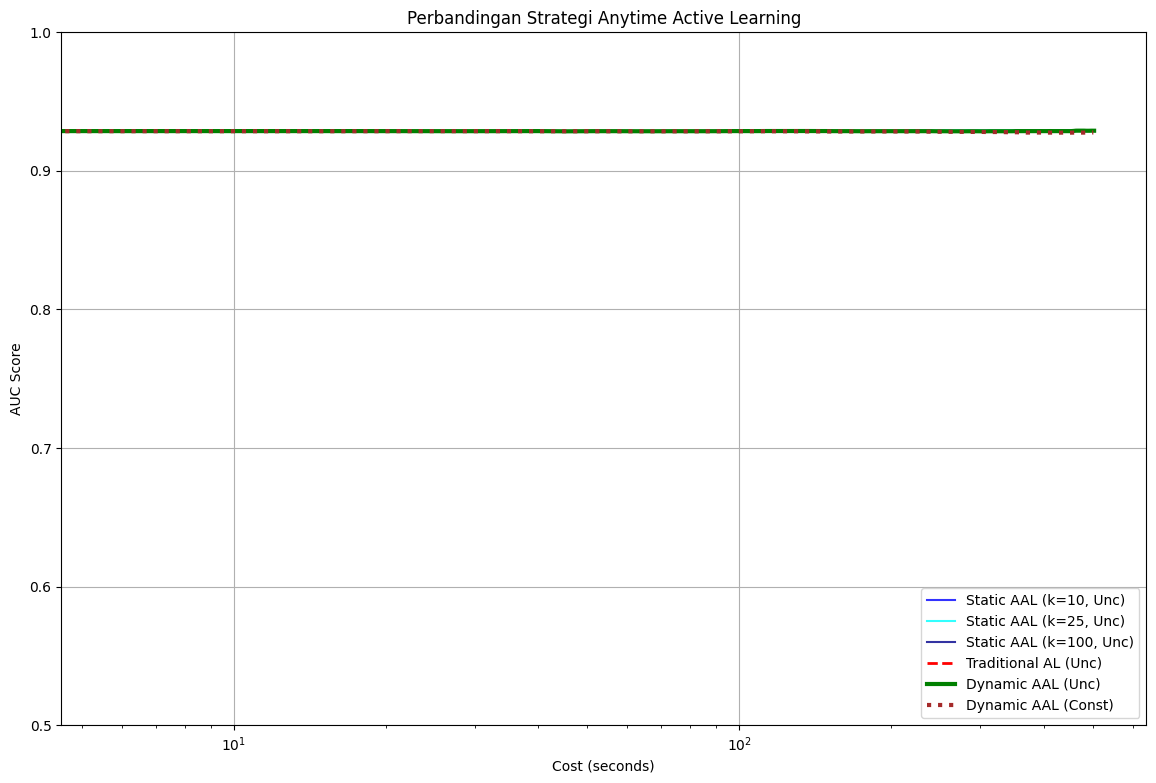

Plot perbandingan telah ditampilkan.


In [12]:
# @title Step 7: Plotting Hasil Perbandingan
print("Step 7: Membuat plot perbandingan hasil eksperimen.")

plt.figure(figsize=(14, 9)) # Ukuran plot yang lebih besar untuk banyak garis

# Plot untuk Static AAL dengan berbagai nilai k (Uncertainty)
plt.plot(cost_static_k10_unc, auc_static_k10_unc, label='Static AAL (k=10, Unc)', linestyle='-', color='blue', alpha=0.8)
plt.plot(cost_static_k25_unc, auc_static_k25_unc, label='Static AAL (k=25, Unc)', linestyle='-', color='cyan', alpha=0.8)
plt.plot(cost_static_k100_unc, auc_static_k100_unc, label='Static AAL (k=100, Unc)', linestyle='-', color='darkblue', alpha=0.8)

# Plot untuk Traditional Active Learning
plt.plot(cost_traditional_al, auc_traditional_al, label='Traditional AL (Unc)', linestyle='--', color='red', linewidth=2)

# Plot untuk Dynamic AAL (Uncertainty)
plt.plot(cost_dynamic_unc, auc_dynamic_unc, label='Dynamic AAL (Unc)', linestyle='-', color='green', linewidth=3)

# Plot untuk Dynamic AAL (Constant Utility)
plt.plot(cost_dynamic_const, auc_dynamic_const, label='Dynamic AAL (Const)', linestyle=':', color='brown', linewidth=3)


plt.xlabel("Cost (seconds)")
plt.ylabel("AUC Score")
plt.title("Perbandingan Strategi Anytime Active Learning")
plt.legend(loc='lower right') # Posisi legend di pojok kanan bawah
plt.grid(True) # Menampilkan grid
plt.xscale('log') # Skala logaritmik untuk sumbu X (biaya) agar lebih mudah dibaca, karena biaya cenderung terdistribusi secara logaritmik.
plt.ylim(0.5, 1.0) # Batasi rentang sumbu Y dari 0.5 (kinerja acak) hingga 1.0 (sempurna)
plt.show()

print("Plot perbandingan telah ditampilkan.")

Step 7: Membuat plot perbandingan hasil eksperimen Dynamic AAL.


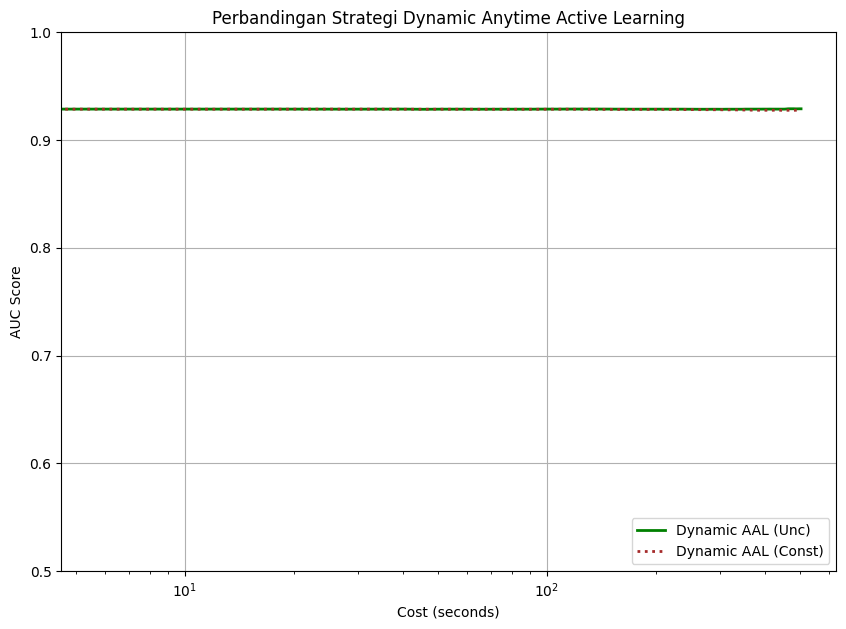

Plot perbandingan Dynamic AAL telah ditampilkan.


In [14]:
# @title Step 7: Plotting Hasil Perbandingan (HANYA DYNAMIC)
print("Step 7: Membuat plot perbandingan hasil eksperimen Dynamic AAL.")

plt.figure(figsize=(10, 7)) # Ukuran plot

# Plot untuk Dynamic AAL (Uncertainty)
plt.plot(cost_dynamic_unc, auc_dynamic_unc, label='Dynamic AAL (Unc)', linestyle='-', color='green', linewidth=2)

# Plot untuk Dynamic AAL (Constant Utility)
plt.plot(cost_dynamic_const, auc_dynamic_const, label='Dynamic AAL (Const)', linestyle=':', color='brown', linewidth=2)


plt.xlabel("Cost (seconds)")
plt.ylabel("AUC Score")
plt.title("Perbandingan Strategi Dynamic Anytime Active Learning")
plt.legend(loc='lower right')
plt.grid(True)
plt.xscale('log')
plt.ylim(0.5, 1.0)
plt.show()

print("Plot perbandingan Dynamic AAL telah ditampilkan.")